<a href="https://colab.research.google.com/github/Sanjayso27/Style_Transfer/blob/main/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

In [ ]:
vgg = models.vgg19(pretrained=True).features
for param in vgg.parameters():
    param.requires_grad_(False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

In [ ]:
vgg._modules.items()

In [9]:
def load_image(img_path, max_size=400, shape=None):
  image = Image.open(img_path).convert('RGB')
  if max(image.size) > max_size:
        size = max_size
  else:
        size = max(image.size)

  if shape is not None:
        size = shape
        
  in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
  #discarding the transparent alpha channel
  image = in_transform(image)[:3,:,:].unsqueeze(0)
    
  return image

In [11]:
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [13]:
def get_features(image, model, layers=None):
  if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## used for calculating the content loss w.r.t target image
                  '28': 'conv5_1'}

  features = {}
  x = image
  # model._modules is a dictionary holding each module in the model
  for name, layer in model._modules.items():
      x = layer(x)
      if name in layers:
          features[layers[name]] = x
          
  return features

In [14]:
def gram_matrix(tensor):
    
    # get the batch_size, depth, height, and width of the Tensor
    b, d, h, w = tensor.size()
    # reshape
    tensor = tensor.view(b * d, h * w)
    
    # calculate the gram matrix
    trans = tensor.t()
    gram = torch.mm(tensor, trans)
    
    return gram

In [31]:
def style_transfer(content,style,lr=0.003):
  content_features = get_features(content, vgg)
  style_features = get_features(style, vgg)
  style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

  target = content.clone().requires_grad_(True).to(device)
  style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

  alpha = 1  
  beta = 1e6 
  #training
  optimi = optim.Adam([target])
  for i in range(2000):
    tar_features = get_features(target,vgg)
    content_loss = torch.mean((tar_features['conv4_2']-content_features['conv4_2'])**2)
    style_loss = 0.0
    for layer in style_grams:
      if(layer=='conv4_2'):
        continue
      tar_gram = gram_matrix(tar_features[layer])
      b,d,h,w = tar_features[layer].size()
      style_loss += (style_weights[layer]*torch.mean((tar_gram-style_grams[layer])**2))/(b*d*h*w)
    tot_loss = alpha*content_loss + beta* style_loss
    optimi.zero_grad()
    tot_loss.backward()
    optimi.step()
    if(i%100==0):
      print(f"loss after {i} epochs: {tot_loss}")
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  ax1.imshow(im_convert(content))
  ax2.imshow(im_convert(target))

loss after 0 epochs: 823973760.0
loss after 100 epochs: 567304192.0
loss after 200 epochs: 448729536.0
loss after 300 epochs: 385543520.0
loss after 400 epochs: 332152288.0
loss after 500 epochs: 279699808.0
loss after 600 epochs: 227612272.0
loss after 700 epochs: 178476960.0
loss after 800 epochs: 135580400.0
loss after 900 epochs: 100962504.0
loss after 1000 epochs: 74764904.0
loss after 1100 epochs: 55750004.0
loss after 1200 epochs: 42250552.0
loss after 1300 epochs: 32773286.0
loss after 1400 epochs: 26147514.0
loss after 1500 epochs: 21501122.0
loss after 1600 epochs: 18191096.0
loss after 1700 epochs: 15760062.0
loss after 1800 epochs: 13904695.0
loss after 1900 epochs: 12431767.0


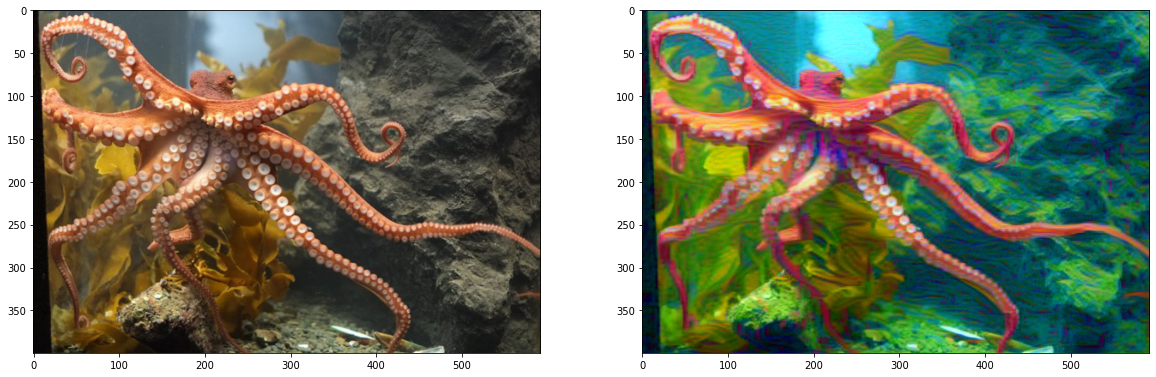

In [32]:
content = load_image('octopus.jpg').to(device)
style = load_image('hockney.jpg', shape=content.shape[-2:]).to(device)
style_transfer(content,style)

loss after 0 epochs: 99317792.0
loss after 100 epochs: 55695780.0
loss after 200 epochs: 40174652.0
loss after 300 epochs: 30680740.0
loss after 400 epochs: 24048450.0
loss after 500 epochs: 19348884.0
loss after 600 epochs: 16129303.0
loss after 700 epochs: 13943987.0
loss after 800 epochs: 12377465.0
loss after 900 epochs: 11147582.0
loss after 1000 epochs: 10106850.0
loss after 1100 epochs: 9185917.0
loss after 1200 epochs: 8353940.0
loss after 1300 epochs: 7594913.5
loss after 1400 epochs: 6900278.5
loss after 1500 epochs: 6263843.0
loss after 1600 epochs: 5681395.5
loss after 1700 epochs: 5149526.5
loss after 1800 epochs: 4665236.0
loss after 1900 epochs: 4224979.5


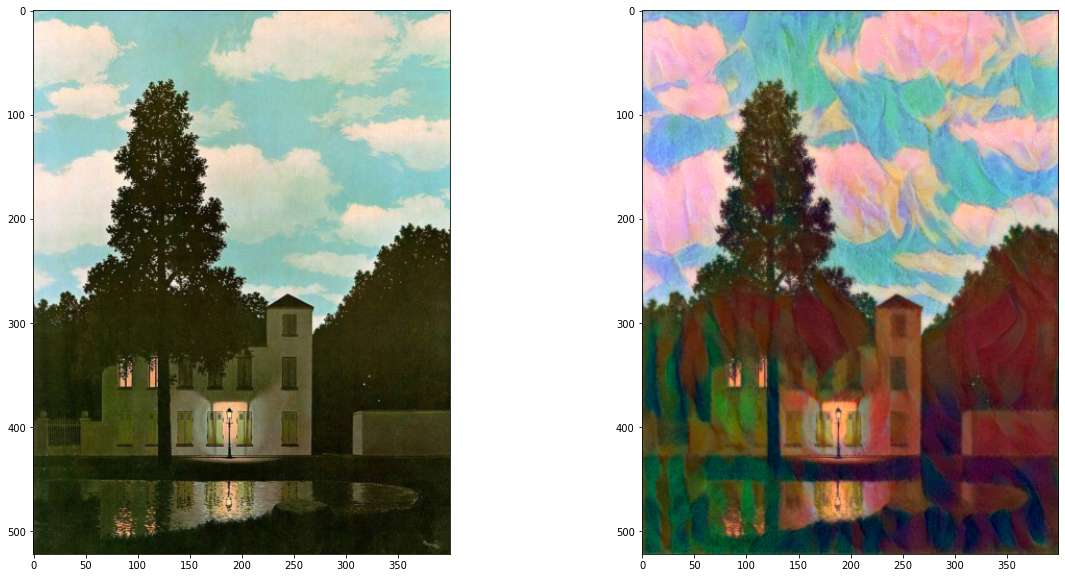

In [34]:
content = load_image('magritte.jpg').to(device)
style = load_image('delaunay.jpg', shape=content.shape[-2:]).to(device)
style_transfer(content,style)